Import libraries:

In [648]:
import re
import nltk
import spacy
import random

import pandas as pd
import seaborn as sns
from random import randint
from wordcloud import WordCloud
from textblob import TextBlob
from tika import parser

from docx import Document
from docx.shared import Cm

from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Image
from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.enums import TA_JUSTIFY, TA_CENTER
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import letter
from reportlab.platypus import Table, TableStyle

from gensim.summarization import mz_keywords
from gensim.summarization.summarizer import summarize

from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag

from pathlib import Path
import wikipediaapi
import concurrent.futures

import winsound
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from requests import get
from googlesearch import search

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize 
import matplotlib.pyplot as plt
from bs4.element import Comment
from bs4 import BeautifulSoup
import urllib.request

import time
import collections
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from nltk import tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from spacy.symbols import nsubj, nsubjpass, VERB, AUX 

from selenium.webdriver.common.keys import Keys
import chromedriver_binary

Import CDFs:

In [426]:
def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    return sources

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_data = {'page': page_name, 'text': page_name.text, 'link': page_name.fullurl,
                 'categories': [[y[9:] for y in list(page_name.categories.keys())]]}
    page_data_df = pd.DataFrame(page_data)
    return page_data_df

def tags(x):
    return nltk.pos_tag(nltk.word_tokenize(x))[0][1]

def scoring(a,b):
    try:
        a = a.replace(',', '').split()
        b = b.replace(',', '').split()
        score = int(100*len(set(a).intersection(b))/(len(set(a))))
    
    except:
        score = 0    
        
    return score

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_normalize(txt, nouns=True):
    processed_text = re.sub('[^a-zA-Z]', ' ', txt)
    processed_text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",processed_text)
    processed_text=re.sub("(\\d|\\W)+"," ",processed_text)

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(processed_text) 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    if nouns==True: 
        tokens = [i for i in tokens if ((tags(i) in ['NN', 'NNP', 'NNS', 'NNPS']) and len(i) > 3)]
    
    return tokens

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)


def word_cloud(tokens):
    stop_words = set(stopwords.words("english"))
    bigrams_list = list(nltk.bigrams(tokens))
    dictionary = [' '.join(tup) for tup in bigrams_list]

    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    words_freq = [(word, bag_of_words.sum(axis=0)[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    wordcloud = WordCloud(stopwords=stop_words, width=300, height=300, random_state=42, max_words=50, prefer_horizontal=1, 
                          background_color='white', max_font_size=256)
    wordcloud.generate_from_frequencies(dict(words_freq))  
    keys = wordcloud.words_
    
    plt.figure(figsize=(7,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.savefig('reports/wordcloud.png')
    plt.show()
    
    return keys 
    
def create_graph(text, nodes=25, max_component=False, common=1000):

    ## Normalize text
    tokens = text_normalize(text)
    ## /Normalize text

    ## create graph
    bigrams=list(nltk.ngrams(tokens, 2))
    bigram_counts = collections.Counter(bigrams)
    bigram_df = pd.DataFrame(bigram_counts.most_common(common), columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    F = nx.Graph()
    for k, v in d[0].items():
            F.add_edge(k[0], k[1], weight=(v*10))
    ## /create graph

    pos = nx.spring_layout(F, iterations=500)
    return F, pos

def parse_page(url):
    htmlString = get(url).text
    soup = BeautifulSoup(htmlString, 'html.parser')
    paragraphs = soup.find_all(['a'])
    txt = text_from_html(str(paragraphs))

    return txt

def get_unique_text(document):
    unique_sentences = []
    for sentence in [sent.raw for sent in TextBlob(document).sentences]:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)

def syntax_full(spacy_sentence):
    result=[] 
    for token in spacy_sentence:
        if (token.dep == nsubj or token.dep == nsubjpass) and (token.head.pos == VERB or token.head.pos == AUX):
            result.append(token.head)
    if result:
        return True
    else:
        return False
    
def tree_graph(d):
    valency_list=[d.get(element) for element in d] #list of valency values
    unique_v_list=list(set(valency_list)) #unique valency values

    unique_v_list.reverse()

    N=5 #number of rows
    T=5 #top words

    v_step=[1/N*step for step in range(0,N)] #list of borders for v values
    v_step.reverse()

    d={k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} #sort d
    levels=[]
    used=[]
    for step in v_step:
        level=[]
        for k in d:
            if d[k]/max(unique_v_list)>step and k not in used:
                level.append(k)
                used.append(k)
        levels.append(level)
    levels=[level for level in levels if level]

    top_levels=[]
    for level in levels:
        if len(level)>T:
            top_levels.append(level[:T])
        else:
            top_levels.append(level)

    levels=top_levels

    gaps=[len(level)-1 for level in levels] #count number of gaps between two words on each level

    lines=[] #get list of strings of every level
    for level in levels:
        level_line=''
        for w in level:
            level_line=level_line+w
        lines.append(level_line)

    longest_symbol_row=max([len(line) for line in lines])+max(gaps)+2 
    ax_step=1/longest_symbol_row #X pos step in the graph

    s=5
    fig = plt.figure(facecolor='#EBF5FB')
    fig.set_size_inches((s+3), s) #set size in inches

    ay_step=1/(len(levels)) #Y pos step in the graph
    i=0
    h_lines_y=[]
    colors=['#D6EAF8','#AED6F1','#85C1E9','#5DADE2','#3498DB']
    
    for level in levels:
        level_line='' #get length of level
        for w in level:
            level_line=level_line+w
        l_step=(longest_symbol_row-len(level_line))/2-gaps[i]/2  #step from the left to start placing words

        h_lines_y.append(1-(i*ay_step))
        color=colors.pop()
        for w in level:
            plt.text(l_step*ax_step+len(w)/2*ax_step, 1-ay_step/2-(i*ay_step), w, fontdict=dict(fontsize=12), 
                     family='monospace', horizontalalignment='center', verticalalignment='center', 
                     bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.2'))
            l_step=l_step+len(w)+1
        i=i+1

    h_lines_y.append(0)
    for y in h_lines_y:
      if y==max(h_lines_y) or y==min(h_lines_y):
        plt.axhline(y=y, color='black')
      else:
        plt.axhline(y=y, color='black', ls='dashed')
   
    plt.axvline(x=0,ymin=min(h_lines_y), ymax=max(h_lines_y), color='black')
    plt.axvline(x=1,ymin=min(h_lines_y), ymax=max(h_lines_y), color='black')
    
    plt.axis('off')
    plt.savefig('reports/graph.png')
    plt.show()

Parameters:

In [448]:
number = 50 #pages
top_number = 20 #keywords 

Create query:

In [707]:
query = input()

wikitext = ''
googletext = ''
arxivtext = ''

text summarization


Parse Wikipedia:

In [708]:
try:
    df = wiki_scrape(query, verbose=True)[:number]
    df = df[['text','link']]
    wikitext = '; '.join(list(df['text'])) 
except:
    wikitext = 'no text found'
    print('Text not found')
    
print('Number of Wiki documents:', len(df)) 
winsound.Beep(2500, 1000)













Links Scraped:   0%|                                                                             | 0/130 [00:00<?, ?/s]











Links Scraped:   1%|▌                                                                    | 1/130 [00:01<02:50,  1.32s/]











Links Scraped:   2%|█                                                                    | 2/130 [00:01<02:06,  1.01/s]











Links Scraped:   4%|██▋                                                                  | 5/130 [00:01<01:27,  1.42/s]











Links Scraped:   5%|███▏                                                                 | 6/130 [00:02<01:15,  1.64/s]











Links Scraped:   5%|███▋                                                                 | 7/130 [00:02<01:03,  1.95/s]











Links Scraped:   8%|█████▊                                                              | 11/130 [00:02<00:46,  2.54/s]











Links Scraped:   9%|██████▎                                            

Links Scraped:  59%|████████████████████████████████████████▎                           | 77/130 [00:12<00:08,  5.91/s]











Links Scraped:  61%|█████████████████████████████████████████▎                          | 79/130 [00:12<00:07,  6.90/s]











Links Scraped:  62%|██████████████████████████████████████████▎                         | 81/130 [00:13<00:06,  7.31/s]











Links Scraped:  63%|██████████████████████████████████████████▉                         | 82/130 [00:13<00:08,  5.92/s]











Links Scraped:  64%|███████████████████████████████████████████▍                        | 83/130 [00:13<00:07,  6.38/s]











Links Scraped:  65%|███████████████████████████████████████████▉                        | 84/130 [00:13<00:06,  6.95/s]











Links Scraped:  66%|████████████████████████████████████████████▉                       | 86/130 [00:13<00:05,  7.41/s]











Links Scraped:  67%|█████████████████████████████████████████████▌                 

Number of Wiki documents: 50


Parse Google:

In [709]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(chrome_options=chrome_options)

google_url = "https://www.google.com/search?q=" + query + "&num=" + str(number+1)
driver.get(google_url)
time.sleep(randint(1,5))

soup = BeautifulSoup(driver.page_source,'lxml')
result_div = soup.find_all('div', attrs={'class': 'g'})

links = []
titles = []
errors = []

descriptions = []
for r in result_div:
    try:
        link = r.find('a', href=True)
        title = None
        title = r.find('h3')

        if isinstance(title,Tag):
            title = title.get_text()

        description = None
        description = r.find('span', attrs={'class': 'st'})

        if isinstance(description, Tag):
            description = description.get_text()

        if link != '' and title != '' and description != '':
            links.append(link['href'])
            titles.append(title)
            descriptions.append(description)

    except Exception as e:
        print(e)
        continue

url_list = links[:(number)]

txt = []
for j in tqdm(url_list):
    delta = random.randint(1,1)
    time.sleep(delta)
    try:  
#         if str(j).endswith('.pdf'): 
#             file_data = parser.from_file(str(j))           
#             t = file_data['content']
#         else:
        t = parse_page(j)
        txt.append(t)
    except:
        print('Parsing error:',str(j))
        errors.append(str(j))
       
summ = '; '.join(txt)
googletext = re.sub('[^A-Za-z0-9.]+', ' ', summ)

print('Number of web pages:', len(url_list))
print('Errors:', errors)
winsound.Beep(2500, 1000)

C:\Users\skamenshchikov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.












  0%|                                                                                           | 0/50 [00:00<?, ?it/s]











  2%|█▋                                                                                 | 1/50 [00:01<01:36,  1.97s/it]











  4%|███▎                                                                               | 2/50 [00:03<01:29,  1.86s/it]











  6%|████▉                                                                              | 3/50 [00:07<01:50,  2.36s/it]











  8%|██████▋                                                                            | 4/50 [00:09<01:56,  2.52s/it]











 10%|████████▎                                                                          | 5/50 [00:12<01:57,  2.61s/it]











 12%|█████████▉            

Parsing error: http://ceur-ws.org/Vol-2410/paper36.pdf














 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:14<01:02,  6.28s/it]











 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:24<01:06,  7.42s/it]











 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:27<00:47,  5.97s/it]











 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:31<00:37,  5.30s/it]











 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:34<00:27,  4.62s/it]











 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:37<00:20,  4.12s/it]











 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:41<00:16,  4.04s/it]











 94%|██████████████████████████████████████████████████████████████████

Number of web pages: 50
Errors: ['http://ceur-ws.org/Vol-2410/paper36.pdf']


Parse Arxiv:

In [710]:
urls = []
closest_value = 200
req = 'https://arxiv.org/search/?query='+query+'&size='+str(closest_value)+'&searchtype=all&source=header&start=0'
htmlString = get(req)

try:
    soup = BeautifulSoup(htmlString.content, 'html5lib') 
    hrefs = soup.find_all('a', {'href': re.compile(r'arxiv.org/abs/')})
    
    if (len(hrefs) > 0):
        for i in hrefs:
            urls.append(i['href'])    

except:
    print ('Connection error')
    
txt = []
for i in tqdm(urls[:number]):
    time.sleep(random.randint(1,8))
    soup = BeautifulSoup(get(str(i)).content, 'html5lib')
    abstract = soup.find('blockquote').text.replace('\n','').replace('  ',' ')
    abstract = ' '.join(abstract.split())
    txt.append(abstract)
         
summ = '; '.join(txt)
arxivtext = re.sub('[^A-Za-z0-9.]+', ' ', summ)
print('Number of web pages:', len(urls[:number]))
winsound.Beep(2500, 1000)













  0%|                                                                                           | 0/50 [00:00<?, ?it/s]











  2%|█▋                                                                                 | 1/50 [00:07<06:20,  7.77s/it]











  4%|███▎                                                                               | 2/50 [00:11<05:17,  6.61s/it]











  6%|████▉                                                                              | 3/50 [00:16<04:39,  5.94s/it]











  8%|██████▋                                                                            | 4/50 [00:20<04:06,  5.36s/it]











 10%|████████▎                                                                          | 5/50 [00:28<04:48,  6.42s/it]











 12%|█████████▉                                                                         | 6/50 [00:34<04:34,  6.24s/it]











 14%|███████████▌                                                      

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:40<00:06,  6.78s/it]











100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:42<00:00,  5.64s/it]


Number of web pages: 50


Statistics:

In [711]:
docs_length = len(df) + len(url_list) + len(urls)
print('Number of documents:',docs_length)

Number of documents: 300


Aggregate text:

In [712]:
# power = min(len(nltk.sent_tokenize(wikitext)),len(nltk.sent_tokenize(googletext)),len(nltk.sent_tokenize(arxivtext)))

# wikitext = ' '.join(nltk.sent_tokenize(wikitext)[:power])
# googletext = ' '.join(nltk.sent_tokenize(googletext)[:power])
# arxivtext = ' '.join(nltk.sent_tokenize(arxivtext)[:power])

final_text = (wikitext + ' ' + googletext + ' ' + arxivtext)
print('Text size:', int(getsizeof(final_text)/1024),'mb')

Text size: 2159 mb


Syntax filter:

In [713]:
final_text = get_unique_text(final_text)
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 50000000

doc = nlp(final_text)
valid_sents=[]

for s in tqdm(list(doc.sents)):
    if syntax_full(s):
        valid_sents.append(s.text)

rawtext = ' '.join(valid_sents)
winsound.Beep(2500, 1000)













  0%|                                                                                        | 0/11777 [00:00<?, ?it/s]











  0%|                                                                                | 1/11777 [00:00<38:51,  5.05it/s]











 12%|████████▉                                                                    | 1371/11777 [00:00<24:02,  7.21it/s]











 27%|█████████████████████▏                                                       | 3236/11777 [00:00<13:48, 10.30it/s]











 52%|████████████████████████████████████████▎                                    | 6172/11777 [00:00<06:20, 14.72it/s]











100%|█████████████████████████████████████████████████████████████████████████| 11777/11777 [00:00<00:00, 18377.89it/s]


CountVec keywords:

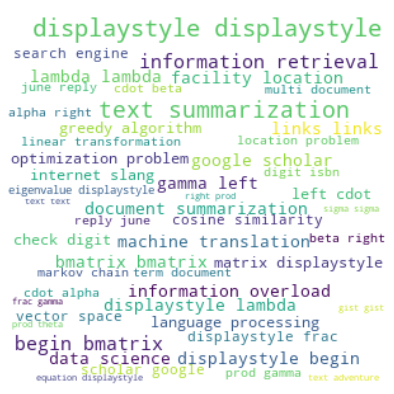

<Countvec Keywords:>

text summarization, begin bmatrix, information retrieval, information overload, displaystyle lambda, machine translation, gamma left, google scholar, data science, displaystyle begin, document summarization, facility location, greedy algorithm, language processing, optimization problem, check digit, internet slang, matrix displaystyle, left cdot, search engine


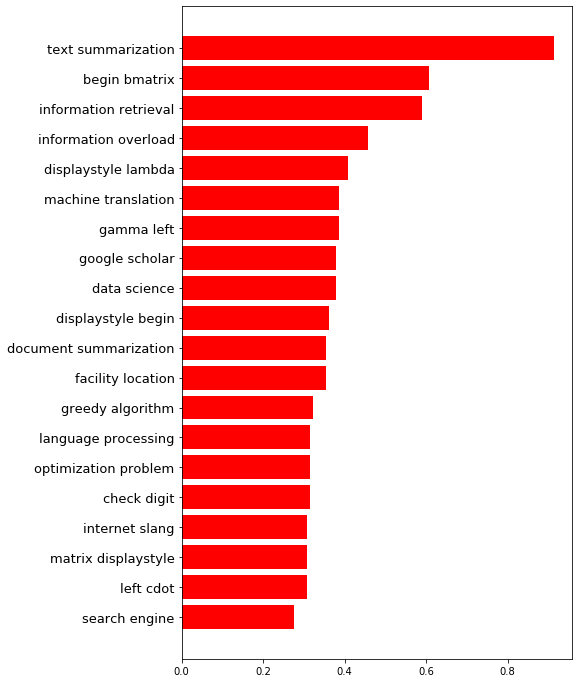

In [714]:
tokens = text_normalize(final_text, nouns=True)
keys = word_cloud(tokens)
keys = [i for i in keys.items() if i[0].split()[0]!=i[0].split()[1]] 
keys = dict(keys[:top_number])

print('<Countvec Keywords:>\n')
print(', '.join(list(keys.keys())))

fig= plt.figure(figsize=(7,12))
plt.barh(range(len(keys)), list(keys.values()), align='center', color='red')
plt.yticks(range(len(keys)), list(keys.keys()),fontsize=13)
plt.gca().invert_yaxis()
plt.show()

winsound.Beep(2500, 1000)

Graph based keywords:

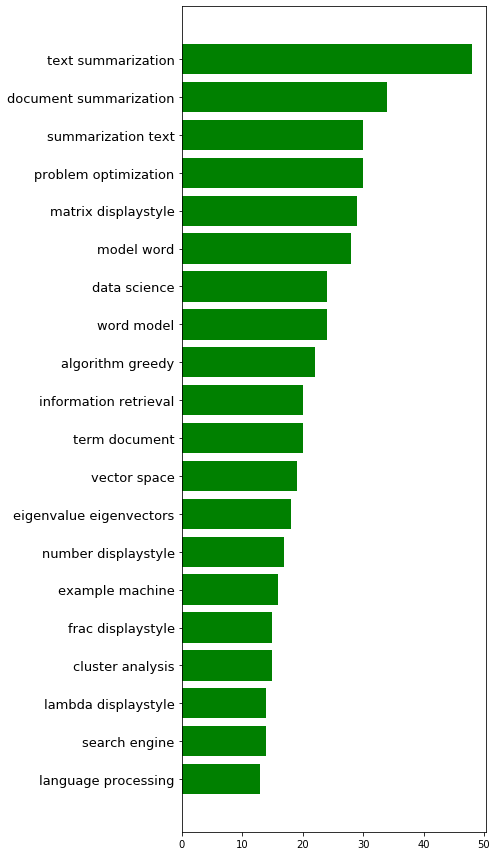

In [715]:
F,pos = create_graph(final_text.lower())

nodes = []
degree = []

for i in F.nodes():   
    nodes.append(i)
    degree.append(F.degree(i))

key_bigrams = []
birams_score = []

x = dict(zip(nodes, degree))
major_nodes = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)})

for i in major_nodes:
    if i!=list(F.neighbors(i))[0]:
        key_bigrams.append(str(i+' '+list(F.neighbors(i))[0]))
        birams_score.append(F.degree[i])
        
key_bigrams = key_bigrams[:top_number]
birams_score = birams_score[:top_number]

bigram_dict = dict(zip(key_bigrams, birams_score))

fig= plt.figure(figsize=(7,12))
plt.barh(range(len(bigram_dict)), list(bigram_dict.values()), align='center', color='green')
plt.yticks(range(len(bigram_dict)), list(bigram_dict.keys()),fontsize=13)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/hist.png')
plt.show()

winsound.Beep(2500, 1000)

Normalization of bigrams:

In [716]:
z = sum(bigram_dict.values())
bigram_dict.update((x, int(round(100*y/z))) for x, y in bigram_dict.items())

normed_keys = []

for i in range(len(bigram_dict.items())):
    normed_keys.append(''.join(str(list(bigram_dict.keys())[i])+' ('+str(list(bigram_dict.values())[i])+'%)'))

key_bigrams = ', '.join(normed_keys)

Get S(I) entropy keywords:

In [704]:
# keys_mz = mz_keywords(final_text, scores=True)

# print('\n<Entropy Keywords:>')
# print(', '.join(list([i[0] for i in keys_mz if len(i[0]) > 3][:30])[:30]))

# top_number = 20
# keys_mz = list([i for i in keys_mz if len(i[0]) > 3][:30])[:30]
# keys = dict(keys_mz[:top_number])

# fig= plt.figure(figsize=(7,12))
# plt.barh(range(len(keys)), list(keys.values()), align='center', color='blue')
# plt.yticks(range(len(keys)), list(keys.keys()),fontsize=13)
# plt.gca().invert_yaxis()
# plt.show()

Create knowledge graph:

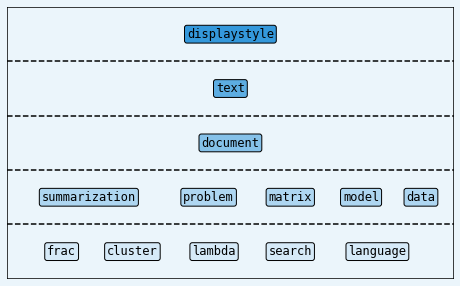

In [717]:
d = dict(F.degree)
tree_graph(d)

Get abstract:

In [718]:
sent_num = 20
ratio = sent_num/len(nltk.sent_tokenize(final_text))
txt = summarize(final_text, ratio=ratio)

print('Compression:', round(100*ratio,1), '%\n')
[print('* ' + i) for i in nltk.sent_tokenize(txt)]

winsound.Beep(2500, 1000)

Compression: 0.4 %

* Automatic summarization is the process of shortening a set of data computationally, to create a subset (a summary) that represents the most important or relevant information within the original content.
* Examples of extracted content include key-phrases that can be used to "tag" or index a text document, or key sentences (including headings) that collectively comprise an abstract, and representative images or video segments, as stated above.
* Such transformation, however, is computationally much more challenging than extraction, involving both natural language processing and often a deep understanding of the domain of the original text in cases where the original document relates to a special field of knowledge.
* Some techniques and algorithms which naturally model summarization problems are TextRank and PageRank, Submodular set function, Determinantal point process, maximal marginal relevance (MMR) etc.
* They can enable document browsing by providing a short 

Create PDF report:

In [719]:
pdf_name = 'reports/summary.pdf'

short_summary = '<br/><br/>'.join([('* ' + i) for i in nltk.sent_tokenize(txt)])

sp = ParagraphStyle('parrafos', alignment=TA_JUSTIFY, fontSize=12, fontName="Times-Roman")
headers = ParagraphStyle('parrafos', alignment=TA_CENTER, fontSize=14, fontName="Times-Roman")
doc = SimpleDocTemplate(pdf_name, pagesize=letter, bottomMargin=.4 * inch, topMargin=.6 * inch, rightMargin=.8 * inch, leftMargin=.8 * inch)

hd = Paragraph('<b>Summary</b>', headers)
P = Paragraph(short_summary, sp)
kw = Paragraph(('\n<b>Keywords</b>: ' + str(key_bigrams) + '.'), sp)
rq = Paragraph(('\n<br /><b>Request</b>: ' + str(query)), sp)
pn = Paragraph(('\n<br /><b>Number of documents:</b>: ' + str(docs_length)), sp)
ts = Paragraph(('\n<br /><b>Text size:</b> ' + str(int(getsizeof(final_text)/1024))) + ' mb', sp)
rq = Paragraph(('\n<br /><b>Number of pages</b>: ' + str(query)), sp)

rs = Paragraph(('\n<br /><b>Resources</b>: ' + str('Wiki, Arxiv, Google')), sp)
space = Paragraph('<br /><br />', sp)

catalog = []
img_hist = Image('reports/hist.png', 3.25*inch, 6.3*inch)

catalog.append(hd)
catalog.append(rq)
catalog.append(rs)
catalog.append(pn)
catalog.append(ts)
catalog.append(space)
catalog.append(kw)
catalog.append(space)
catalog.append(P)

doc.build(catalog)

Create DOCX report:

In [721]:
short_summary = '\n'.join([('* ' + i + '\n') for i in nltk.sent_tokenize(txt)])

doc = Document()
hd = doc.add_paragraph()
hd.add_run('Summary').bold = True
hd = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', ('Request: ' + str(query))))
hd = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', ('Resources: ' + str('Wiki, ' + 'Arxiv, ' + 'Google, '))))
hd = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', ('Number of documents: ' + str(docs_length))))
hd = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', ('Text size: ' + str(str(int(getsizeof(final_text)/1024))) + ' mb')))
hd = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', ('Keywords: ' + str(key_bigrams))))

hd.alignment = 3

r = hd.add_run()
# wcloud = r.add_picture('/home/kamphys/mysite/static/img/cloud.png')
# wcloud.width = Cm(6)
# wcloud.height = Cm(6)

# graph = r.add_picture('/home/kamphys/mysite/static/img/graph.png')
# graph.height = Cm(6)
# graph.width = Cm(8)

par = doc.add_paragraph(re.sub(r'[^\x00-\x7F]+|\x0c',' ', (short_summary.replace('.','. '))))
par.alignment = 0

doc.save('reports/summary.docx')

In [693]:
# import docx as ds

# def getText(filename):
#     doc = ds.Document(filename)
#     fullText = []
#     for para in doc.paragraphs:
#         fullText.append(para.text)
#     return '\n'.join(fullText)


from docx import Document
import os
#document = open('book1.docx')
document = Document('docs/summy.docx')

txt = []

for p in document.paragraphs:
    txt.append(p.text)
    
txt = ''.join(txt)    

In [678]:
txt

'In this paper mechanisms of reversion - momentum transition are considered. Two basic nonlinear mechanisms are highlighted: a slow and fast bifurcation. A slow bifurcation leads to the equilibrium evolution, preceded by stability loss delay of a control parameter. A single order parameter is introduced by Markovian chain diffusion, which plays a role of a precursor. A fast bifurcation is formed by a singular fusion of unstable and stable equilibrium states. The effect of a precatastrophic range compression is observed before the discrete change of a system. A diffusion time scaling is presented as a precursor of the fast bifurcation. The efficiency of both precursors in a currency market was illustrated by simulation of a prototype of a trading system. Keywords: Switching point; Market transition; nonlinear analysis; Price action filter; trading system 1. Introduction Two general classes may be considered among the quantitative trading systems: mean reversion and momentum-based system

In [669]:
getText('docs/summy.docx')

'In this paper mechanisms of reversion - momentum transition are considered. Two basic nonlinear mechanisms are highlighted: a slow and fast bifurcation. A slow bifurcation leads to the equilibrium evolution, preceded by stability loss delay of a control parameter. A single order parameter is introduced by Markovian chain diffusion, which plays a role of a precursor. A fast bifurcation is formed by a singular fusion of unstable and stable equilibrium states. The effect of a precatastrophic range compression is observed before the discrete change of a system. A diffusion time scaling is presented as a precursor of the fast bifurcation. The efficiency of both precursors in a currency market was illustrated by simulation of a prototype of a trading system. Keywords: Switching point; Market transition; nonlinear analysis; Price action filter; trading system 1. Introduction Two general classes may be considered among the quantitative trading systems: mean reversion and momentum-based system